# 訓練 GAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pypianoroll
import pygame
import os
from mido import MidiFile
import wave
import pylab as pl
import glob
from pydub import AudioSegment
from pydub.utils import make_chunks
import tensorflow as tf

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


D:\python_sys\envs\tensorflow\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
D:\python_sys\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [58]:
wave_data = []
for data in glob.glob('canon/*ch*.wav'):
    f = wave.open(data, "rb")
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    str_data = f.readframes(nframes)
    f.close()
    wavedata = np.fromstring(str_data, dtype=np.short)
    wavedata.shape = -1, 2
    wavedata = wavedata.T
    wave_data.append(wavedata[0])
    wave_data.append(wavedata[1])
# time = np.arange(0, nframes) * (1.0 / framerate)
# pl.subplot(211) 
# pl.plot(time, wave_data[0])
# pl.subplot(212) 
# pl.plot(time, wave_data[1], c="g")
# pl.xlabel("time (seconds)")
# pl.show()

D:\python_sys\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


(37200, 441)


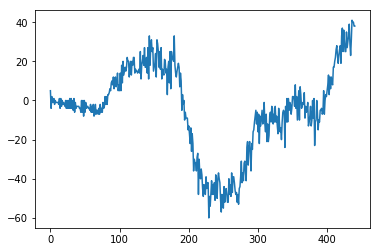

In [59]:
wave_data = np.array(wave_data)
print(wave_data.shape)
plt.plot(wave_data[0])

In [151]:
import keras
from keras.layers import Dense, Dropout, Input,BatchNormalization,Conv1D,Activation,Reshape,Flatten
from keras.models import Model,Sequential
from tqdm import tqdm
from keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split

In [152]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [173]:
def get_generative(G_in, dense_dim=200, out_dim=441, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
#     opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer='adam')
    return G, G_out
G_in = Input(shape=[10])
G, G_out = get_generative(G_in)
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_307 (Dense)            (None, 200)               2200      
_________________________________________________________________
activation_6 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_308 (Dense)            (None, 441)               88641     
Total params: 90,841
Trainable params: 90,841
Non-trainable params: 0
_________________________________________________________________


In [176]:
def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=32, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
#     x = Dropout(drate)(x)
    x = Conv1D(64, 3, activation='relu')(x)
#     x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    x = Dropout(0.5)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

D_in = Input(shape=[441])
D, D_out = get_discriminative(D_in)
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 441)               0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 441, 1)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 437, 32)           192       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 435, 64)           6208      
_________________________________________________________________
flatten_6 (Flatten)          (None, 27840)             0         
_________________________________________________________________
dense_311 (Dense)            (None, 32)                890912    
_________________________________________________________________
dropout_81 (Dropout)         (None, 32)                0         
__________

In [179]:
def sample_data_and_gen(G, noise_dim=10, n_samples=10000):
    XT = wave_data[0:n_samples]
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y

def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=128):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)

pretrain(G, D)

Epoch 1/1
20000/20000 [==============================] - ETA: 6:39 - loss: 5.714 - ETA: 3:28 - loss: 6.742 - ETA: 2:24 - loss: 7.320 - ETA: 1:52 - loss: 7.662 - ETA: 1:33 - loss: 7.787 - ETA: 1:20 - loss: 7.618 - ETA: 1:10 - loss: 7.711 - ETA: 1:04 - loss: 7.874 - ETA: 58s - loss: 8.057 - ETA: 54s - loss: 8.14 - ETA: 50s - loss: 8.17 - ETA: 47s - loss: 8.10 - ETA: 45s - loss: 8.05 - ETA: 42s - loss: 8.03 - ETA: 40s - loss: 7.99 - ETA: 39s - loss: 8.06 - ETA: 37s - loss: 8.06 - ETA: 36s - loss: 8.01 - ETA: 35s - loss: 8.02 - ETA: 33s - loss: 8.06 - ETA: 32s - loss: 8.06 - ETA: 31s - loss: 8.05 - ETA: 31s - loss: 8.02 - ETA: 30s - loss: 8.04 - ETA: 29s - loss: 8.06 - ETA: 28s - loss: 8.03 - ETA: 28s - loss: 8.03 - ETA: 27s - loss: 8.02 - ETA: 27s - loss: 8.03 - ETA: 26s - loss: 8.01 - ETA: 25s - loss: 8.02 - ETA: 25s - loss: 8.04 - ETA: 24s - loss: 8.04 - ETA: 24s - loss: 8.05 - ETA: 24s - loss: 8.03 - ETA: 23s - loss: 8.05 - ETA: 23s - loss: 8.04 - ETA: 22s - loss: 8.06 - ETA: 22s - los

In [181]:
def sample_noise(G, noise_dim=10, n_samples=500):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

def train(GAN, G, D, epochs=50, n_samples=500, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss

d_loss, g_loss = train(GAN, G, D, verbose=True)



  0%|                                                                                                | 0/50 [00:00<?, ?it/s]

  2%|█▊                                                                                      | 1/50 [00:06<05:06,  6.25s/it]

  4%|███▌                                                                                    | 2/50 [00:07<03:45,  4.70s/it]

  6%|█████▎                                                                                  | 3/50 [00:08<02:49,  3.61s/it]

  8%|███████                                                                                 | 4/50 [00:09<02:12,  2.89s/it]

 10%|████████▊                                                                               | 5/50 [00:10<01:45,  2.34s/it]

 12%|██████████▌                                                                             | 6/50 [00:11<01:26,  1.97s/it]

 14%|████████████▎                                                                           | 7/50 [00:12<01:13,  1

Epoch #50: Generative Loss: 15.780234336853027, Discriminative Loss: 8.01513957977295




100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.12s/it]